In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import linregress
import lmfit
import copy
import graphviz

plt.ioff()
plt.style.use('bmh')
%config InlineBackend.figure_format = 'svg'

%load_ext watermark

In [2]:
%watermark -v -p numpy,pandas,matplotlib,scipy,lmfit

# CPython 3.6.4
# IPython 6.2.1
#
# numpy 1.14.0
# pandas 0.22.0
# matplotlib 2.1.2
# scipy 1.0.0
# lmfit 0.9.7

CPython 3.6.4
IPython 6.2.1

numpy 1.14.0
pandas 0.22.0
matplotlib 2.1.2
scipy 1.0.0
lmfit 0.9.7


In [3]:
exp_data1 = pd.read_csv('data_onefilter.txt', delimiter='\t', index_col=False)

time1 = exp_data1['time'].values
concentration1 = exp_data1['concentration'].values
volume1 = exp_data1['volume'].values

Vol = 670  # mL, measured by filling with water
c_input = 4.94  # mg/mL
c_init = concentration1[0]  # ca. 3.0 mg/mL
q_init = c_input - c_init  # ca. 1.9 mg/mL

linfit1 = linregress(time1, volume1)
Vdot1 = linfit1.slope  # ca. 0.38 mL/s

In [4]:
exp_data2 = pd.read_csv('data_twofilters.txt', delimiter='\t', index_col=False)

time2 = exp_data2['time'].values
concentration2 = exp_data2['concentration'].values
volume2 = exp_data2['volume'].values

linfit2 = linregress(time2, volume2)
Vdot2 = linfit2.slope  # ca. 1.42 mL/s

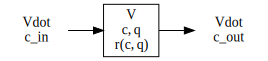

In [5]:
dia1 = graphviz.Digraph()
dia1.graph_attr['rankdir'] = 'LR'
dia1.node('in', label='Vdot\nc_in', color='white')
dia1.node('reactor', label='V\nc, q\n r(c, q)', shape='box')
dia1.node('out', label='Vdot\nc_out', color='white')
dia1.edge('in', 'reactor')
dia1.edge('reactor','out')
dia1

In [6]:
def rates(state, t, paras):
    c, q = state
    k1, k2, qmax, vol, vdot = paras

    dcdt = vdot / vol * (c_input - c) - k1 * c * (qmax - q) + k2 * q
    dqdt = k1 * c * (qmax - q) - k2 * q
    return [dcdt, dqdt]


def conc(t, c0, q0, k1, k2, qmax, v, vdot):
    initial_state = (c0, q0)
    params_list = [k1, k2, qmax, v, vdot]

    x = odeint(rates, initial_state, t, args=(params_list, ))
    return x


def conc_index(t, c0, q0, k1, k2, qmax, index, v, vdot):
    x = conc(t, c0, q0, k1, k2, qmax, v, vdot)
    return x[:, index]

In [7]:
def rates_twofilters(state, t, paras):
    c1, q1, c2, q2 = state
    k1, k2, qmax, vol, vdot = paras

    dc1dt = vdot / vol * (c_input - c1) - k1 * c1 * (qmax - q1) + k2 * q1
    dq1dt = k1 * c1 * (qmax - q1) - k2 * q1

    dc2dt = vdot / vol * (c1 - c2) - k1 * c2 * (qmax - q2) + k2 * q2
    dq2dt = k1 * c2 * (qmax - q2) - k2 * q2
    return [dc1dt, dq1dt, dc2dt, dq2dt]


def conc_twofilters(t, initial_state, paras):
    x = odeint(rates_twofilters, initial_state, t, args=(paras,))
    return x

In [8]:
c_model = lmfit.Model(conc_index, independent_vars=['t', 'index'])

In [9]:
params1 = c_model.make_params()

params1['k1'].value = 0.1
params1['k2'].value = 0
params1['qmax'].value = 1
params1['c0'].value = c_init
params1['q0'].value = q_init
params1['v'].value = Vol
params1['vdot'].value = Vdot1

params1['k1'].vary = True
params1['k2'].vary = True
params1['qmax'].vary = True
params1['c0'].vary = False
params1['q0'].vary = False
params1['v'].vary = False
params1['vdot'].vary = False

In [10]:
lmfit_results1 = c_model.fit(concentration1, params1, t=time1, index=0, method='nelder')
#print(lmfit_results1.fit_report())

C:\Users\pyao1\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [11]:
#fig, ax = plt.subplots()

#ax.plot(time1, lmfit_results1.eval())
#ax.plot(time1, concentration1, marker='o', markerfacecolor='None', 
#        linestyle='None', markersize=4)
#ax.set_xlabel('Time (s)')
#ax.set_ylabel(r'$c$ (mg/mL)')

#fig.show()

In [12]:
protein_loss = (volume1[1:]-volume1[:-1]) * c_input - (volume1[1:]-volume1[:-1]) * concentration1[1:]

In [13]:
params2 = c_model.make_params()

params2['k1'].value = 0.01
params2['k2'].value = 0.001
params2['qmax'].value = protein_loss.sum() / Vol

params2['c0'].value = c_init
params2['q0'].value = q_init
params2['v'].value = Vol
params2['vdot'].value = Vdot1

params2['k1'].vary = True
params2['k2'].vary = True
params2['qmax'].vary = False
params2['c0'].vary = False
params2['q0'].vary = False
params2['v'].vary = False
params2['vdot'].vary = False

In [14]:
lmfit_results2 = c_model.fit(concentration1, params2, t=time1, index=0, method='nelder')
#print(lmfit_results2.fit_report())

In [15]:
params3 = c_model.make_params()

params3['k1'].value = 0.01
params3['k2'].value = 0
params3['qmax'].value = protein_loss.sum() / Vol

params3['c0'].value = c_init
params3['q0'].value = q_init
params3['v'].value = Vol
params3['vdot'].value = Vdot1

params3['k1'].vary = True
params3['k2'].vary = False
params3['qmax'].vary = False
params3['c0'].vary = False
params3['q0'].vary = False
params3['v'].vary = False
params3['vdot'].vary = False

In [16]:
lmfit_results3 = c_model.fit(concentration1, params3, t=time1, index=0, method='nelder')
#print(lmfit_results3.fit_report())

In [17]:
params = copy.deepcopy(params2)
lmfit_results = c_model.fit(concentration1, params, t=time1, index=0, method='nelder')

In [18]:
#fig, (ax1, ax2) = plt.subplots(1, 2)

#ax1.plot(time1, lmfit_results.eval(index=0))
#ax1.set_xlabel('Time (s)')
#ax1.set_ylabel('mg/mL')
#ax1.set_title(r'$c$')

#ax2.plot(time1, c_model.eval(lmfit_results.params, t=time1, index=1))
#ax2.set_xlabel('Time (s)')
#ax2.set_ylabel('mg/mL')
#ax2.set_title(r'$q$')

#fig.set_size_inches(15/2.54, 7.5/2.54)
#fig.tight_layout()
#fig.show()

In [19]:
k1_lmfit = lmfit_results.params['k1'].value
k2_lmfit = lmfit_results.params['k2'].value
qmax_lmfit = lmfit_results.params['qmax'].value

In [20]:
Vdot_fill = 670 / 16  # 41.875 mL/s

v_fill = np.arange(0, 670, 1)
t_fill = v_fill / Vdot_fill

fill = c_model.eval(lmfit_results.params, vdot=Vdot_fill, t=t_fill, index=[0,1])

In [21]:
#fig, (ax1, ax2) = plt.subplots(1, 2)

#ax1.plot(t_fill, fill[:, 0])
#ax1.set_xlabel('Time (s)')
#ax1.set_ylabel('mg/mL')
#ax1.set_title(r'$c$')

#ax2.plot(t_fill, fill[:, 1])
#ax2.set_xlabel('Time (s)')
#ax2.set_ylabel('mg/mL')
#ax2.set_title(r'$q$')

#fig.set_size_inches(15/2.54, 7.5/2.54)
#fig.tight_layout()
#fig.show()

In [22]:
avg_fill = (np.trapz(Vdot_fill * fill[:,0],x=t_fill) /
            np.trapz(np.repeat(Vdot_fill, len(t_fill)), x=t_fill))

In [23]:
t_hold = np.arange(0,300,1)

In [24]:
hold1 = c_model.eval(lmfit_results.params, c0=fill[-1,0], q0=fill[-1,1], 
                     vdot=0, t=t_hold, index=[0,1])

In [25]:
hold2 = c_model.eval(lmfit_results.params, c0=avg_fill, q0=0, 
                     vdot=0, t=t_hold, index=[0,1])

In [26]:
init_state = hold1[-1,0], hold1[-1,1], hold2[-1,0], hold2[-1,1]

In [27]:
t_collect = np.arange(0, 3001, 10)
twofilters = conc_twofilters(t_collect, init_state, [k1_lmfit, k2_lmfit, qmax_lmfit, Vol, Vdot2])

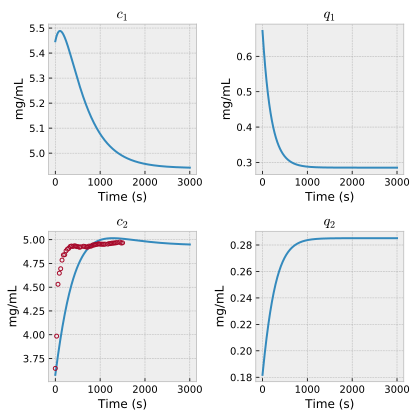

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(t_collect, twofilters[:,0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c_1$')

ax2.plot(t_collect, twofilters[:,1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q_1$')

ax3.plot(t_collect, twofilters[:,2])
ax3.plot(time2, concentration2, marker='o', markerfacecolor='None', 
         linestyle='None', markersize=4)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('mg/mL')
ax3.set_title(r'$c_2$')

ax4.plot(t_collect, twofilters[:,3])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('mg/mL')
ax4.set_title(r'$q_2$')

fig.set_size_inches(15/2.54, 15/2.54)
fig.tight_layout()
#fig.show()

In [29]:
t_total = np.concatenate((t_fill, t_fill[-1]+t_hold, t_hold[-1]+t_collect))
c1_total = np.concatenate((fill[:,0], hold1[:,0], twofilters[:,0]))
q1_total = np.concatenate((fill[:,1], hold1[:,1], twofilters[:,1]))
c2_total = np.concatenate((np.repeat(0,len(t_fill)), hold2[:,0], twofilters[:,2]))
q2_total = np.concatenate((np.repeat(0,len(t_fill)), hold2[:,1], twofilters[:,3]))

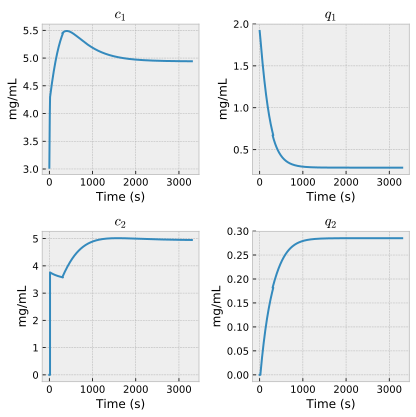

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(t_total, c1_total)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c_1$')

ax2.plot(t_total, q1_total)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q_1$')

ax3.plot(t_total, c2_total)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('mg/mL')
ax3.set_title(r'$c_2$')

ax4.plot(t_total, q2_total)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('mg/mL')
ax4.set_title(r'$q_2$')

fig.set_size_inches(15/2.54, 15/2.54)
fig.tight_layout()
# fig.show()

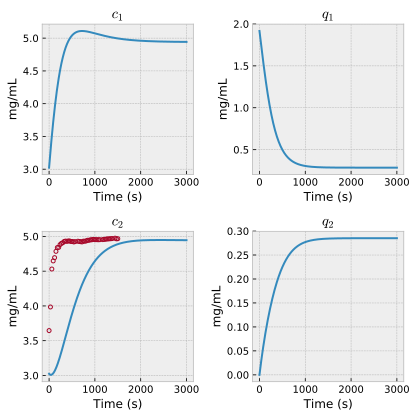

In [31]:
init_state = c_init, q_init, c_init, 0

t_collect = np.arange(0, 3001, 10)
twofilters = conc_twofilters(t_collect, init_state, [k1_lmfit, k2_lmfit, qmax_lmfit, Vol, Vdot2])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(t_collect, twofilters[:,0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c_1$')

ax2.plot(t_collect, twofilters[:,1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q_1$')

ax3.plot(t_collect, twofilters[:,2])
ax3.plot(time2, concentration2, marker='o', markerfacecolor='None', 
         linestyle='None', markersize=4)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('mg/mL')
ax3.set_title(r'$c_2$')

ax4.plot(t_collect, twofilters[:,3])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('mg/mL')
ax4.set_title(r'$q_2$')

fig.set_size_inches(15/2.54, 15/2.54)
fig.tight_layout()
#fig.show()